In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.models import load_model



%matplotlib inline

In [31]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [32]:
train_df = pd.read_csv("../nih/train-small.csv")
valid_df = pd.read_csv("../nih/valid-small.csv")
test_df = pd.read_csv("../nih/test.csv")

train_df.head()

,Image,PatientId,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00011293_002.png,11293,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00015562_003.png,15562,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,00016404_000.png,16404,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00005772_003.png,5772,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00013473_000.png,13473,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
test_df.shape

(420, 16)

In [34]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [7]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 # boolean (true if there is at least 1 patient in both groups)
    
    ### END CODE HERE ###
    
    return leakage

In [8]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [9]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [10]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [11]:
IMAGE_DIR = "../xray_dataset/images/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)


getting train generator...
Found 1000 validated image filenames.


In [12]:
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.6598 and the minimum is -3.9797
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


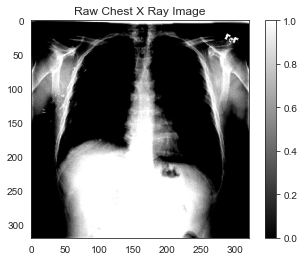

In [49]:
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [53]:
import os
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(IMAGE_DIR, sample_img))
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 320, 320, 3) (320, 320, 3)
(1024, 1024)


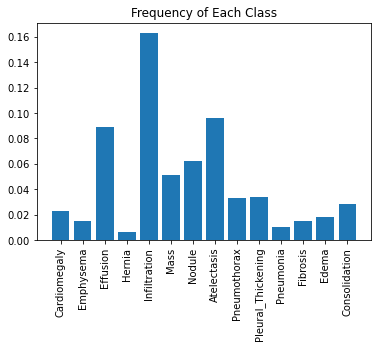

In [15]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [37]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels == 1,axis=0) / N
    negative_frequencies = np.sum(labels == 0,axis=0) / N

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [38]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


In [18]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.023, 0.015, 0.089, 0.006, 0.163, 0.051, 0.062, 0.096, 0.033,
       0.034, 0.01 , 0.015, 0.018, 0.028])

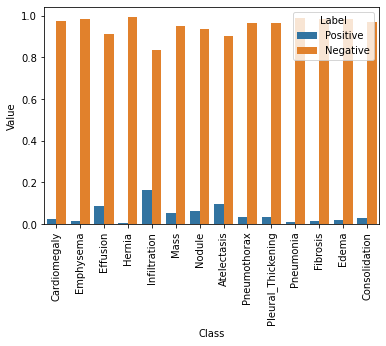

In [19]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [20]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

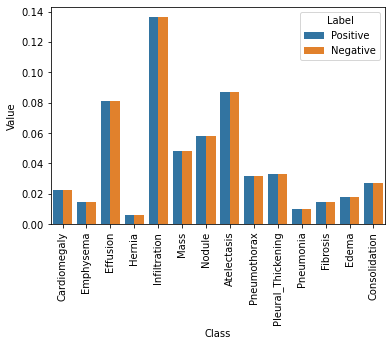

In [21]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [39]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) #complete this line
            return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [40]:
# Test

with tf.compat.v1.Session() as sess:
    print("Test example:\n")
    y_true = K.constant(np.array(
        [[1, 1, 1],
         [1, 1, 0],
         [0, 1, 0],
         [1, 0, 1]]
    ))
    print("y_true:\n")
    print(y_true.eval())

    w_p = np.array([0.25, 0.25, 0.5])
    w_n = np.array([0.75, 0.75, 0.5])
    print("\nw_p:\n")
    print(w_p)

    print("\nw_n:\n")
    print(w_n)

    y_pred_1 = K.constant(0.7*np.ones(y_true.shape))
    print("\ny_pred_1:\n")
    print(y_pred_1.eval())

    y_pred_2 = K.constant(0.3*np.ones(y_true.shape))
    print("\ny_pred_2:\n")
    print(y_pred_2.eval())

    # test with a large epsilon in order to catch errors
    L = get_weighted_loss(w_p, w_n, epsilon=1)

    print("\nIf we weighted them correctly, we expect the two losses to be the same.")
    L1 = L(y_true, y_pred_1).eval()
    L2 = L(y_true, y_pred_2).eval()
    print(f"\nL(y_pred_1)= {L1:.4f}, L(y_pred_2)= {L2:.4f}")
    print(f"Difference is L1 - L2 = {L1 - L2:.4f}")

Test example:

y_true:

[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

w_p:

[0.25 0.25 0.5 ]

w_n:

[0.75 0.75 0.5 ]

y_pred_1:

[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2:

[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If we weighted them correctly, we expect the two losses to be the same.

L(y_pred_1)= -0.1487, L(y_pred_2)= -0.1487
Difference is L1 - L2 = 0.0000


In [41]:
# create the base pre-trained model
base_model = DenseNet121(weights='./DenseNet-BC-121-32-no-top.h5', include_top=False);

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [46]:
def load_C3M3_model():
   
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model =  DenseNet121(weights='./DenseNet-BC-121-32-no-top.h5', include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    #model.load_weights("nih_new/pretrained_model.h5")
    print("Loaded Weights")
    return model

In [47]:
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


In [48]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 25 steps
Epoch 1/3
  1/100 [..............................] - ETA: 3:22

TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int64 of argument 'x'.